## Problem Statement

The number of reported results vary daily. Develop a model to explain this variation and use your model to create a prediction interval for the number of reported results on March 1, 2023. Do any attributes of the word affect the percentage of scores reported that were played in Hard Mode? If so, how? If not, why not?

In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pmdarima import auto_arima
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

In [74]:
import warnings
warnings.filterwarnings("ignore")

First, read the dataset for the dates and their corresponding number of reported results, and visualize the data.

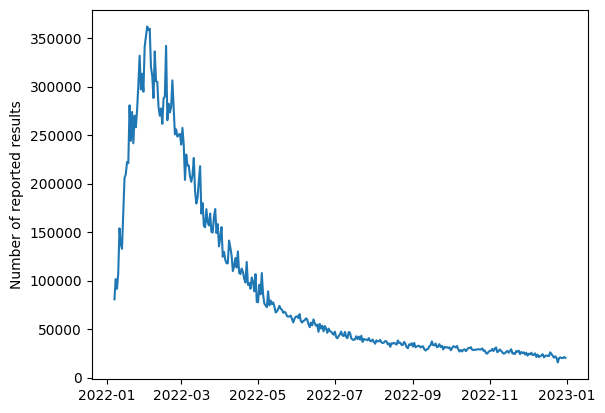

In [75]:
df = pd.read_excel("./dataset/wordle_data.xlsx", index_col=0, usecols="A,D")
df = df.sort_index()
plt.plot(df)
plt.ylabel("Number of reported results")
plt.show()

We first normalize the data to $[0,1]$ scale.

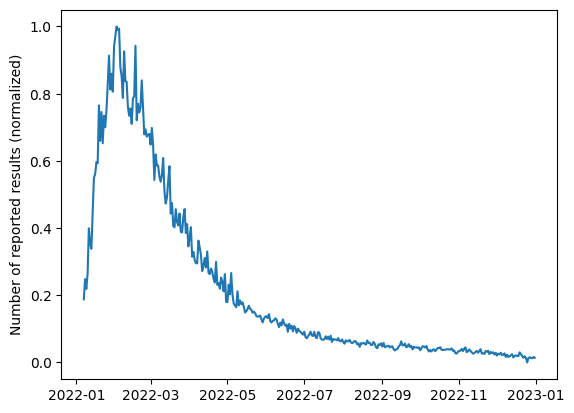

In [76]:
orimin, orimax = df["result_num"].min(), df["result_num"].max()
df = (df - orimin) / (orimax - orimin)
plt.plot(df)
plt.ylabel("Number of reported results (normalized)")
plt.show()

We are now going to check for stationarity of the dataset.

In [77]:
dftest = adfuller(df, autolag="AIC")
print("p-value: {:.2e}, statistically significant: {}".format(dftest[1], dftest[1] < 0.05))

p-value: 1.88e-03, statistically significant: True


ARIMA, which stands for Autoregression Integrated Moving Image, is a model for prediction in time series analysis. We are now going to figure out the orders that will be used in our ARIMA model.

In [78]:
autofit = auto_arima(df, trace=True, suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-1384.933, Time=0.59 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1340.556, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1388.661, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1383.328, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1342.494, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-1386.817, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1386.989, Time=0.27 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-1384.665, Time=0.22 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-1390.503, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-1388.665, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-1388.761, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-1385.134, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-1386.510, Time=0.17 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 1.903 seconds


From the previous tracing results, we can see that our best model would be `ARIMA(1,1,0)`, and now we need to split the dataset into a training set and a testing set, and start the training process.

In [79]:
df_train, df_test = df[:-31], df[-31:]
model = ARIMA(df_train, order=(1, 1, 0))
model = model.fit()

Now we can make our prediction and compare with the test set to validate the accuracy and correctness of our trained model.

In [80]:
test_fit = model.predict(start=len(df_train), end=len(df_train)+len(df_test)-1, type="levels")
mse = np.linalg.norm(test_fit - df_test.to_numpy().reshape(-1))
print("Mean squared error: {:.5f}".format(mse))

Mean squared error: 0.05739


Now we can plot our prediction result.

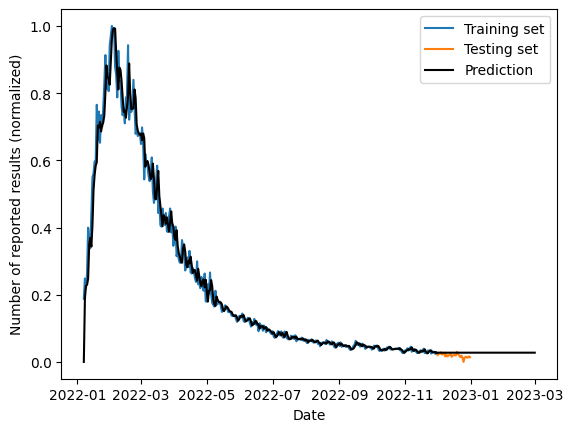

In [81]:
prediction = model.predict(start=0, end=418, type="levels")
plt.plot(df_train, label="Training set")
plt.plot(df_test, label="Testing set")
plt.plot(prediction, label="Prediction", color="black")
plt.xlabel("Date")
plt.ylabel("Number of reported results (normalized)")
plt.legend()
plt.show()

Moreover, we can predict the number of reported results on 2023/03/01.

In [82]:
print("Result:", int(prediction[-1] * (orimax - orimin) + orimin))

Result: 25084
